# 🧠 Demonstração: Detecção de Fraude Neuromórfica

**Descrição:** Notebook interativo demonstrando o pipeline completo de detecção de fraude usando Spiking Neural Networks (SNNs), incluindo codificação de spikes, treinamento STDP, e análise de performance.

**Autor:** Mauro Risonho de Paula Assumpção  
**Data de Criação:** 5 de Dezembro de 2025  
**Licença:** MIT License

---

Este notebook demonstra o pipeline completo de detecção de fraude usando Spiking Neural Networks (SNNs).

## Conteúdo
1. Setup e Importações
2. Geração de Dados Sintéticos
3. Codificação de Spikes
4. Arquitetura da SNN
5. Treinamento com STDP
6. Inferência e Avaliação
7. Visualizações

In [1]:
import sys
import os
from pathlib import Path

# Adicionar src ao path
# Notebook está em: Projeto-Neuromorfico-X/portfolio/01_fraud_neuromorphic/notebooks/
# src está em: Projeto-Neuromorfico-X/portfolio/01_fraud_neuromorphic/src/
notebook_dir = Path.cwd()

# Verificar se estamos no diretório raiz do projeto ou no diretório notebooks
if (notebook_dir / 'portfolio' / '01_fraud_neuromorphic' / 'src').exists():
    # Estamos na raiz do projeto (Projeto-Neuromorfico-X)
    src_path = notebook_dir / 'portfolio' / '01_fraud_neuromorphic' / 'src'
elif (notebook_dir.parent / 'src').exists():
    # Estamos em notebooks/
    src_path = notebook_dir.parent / 'src'
elif (notebook_dir / 'src').exists():
    # Estamos em 01_fraud_neuromorphic/
    src_path = notebook_dir / 'src'
else:
    src_path = None

if src_path and src_path.exists():
    if str(src_path) not in sys.path:
        sys.path.insert(0, str(src_path))
    print(f"✅ Diretório src adicionado: {src_path}")
else:
    print(f"❌ Diretório src não encontrado!")
    print(f"   Notebook dir: {notebook_dir}")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
from tqdm.auto import tqdm

# Nossos módulos
try:
    from main import FraudDetectionPipeline, generate_synthetic_transactions
    from encoders import RateEncoder, TemporalEncoder, PopulationEncoder, TransactionEncoder
    from models_snn import FraudSNN, demonstrate_lif_neuron
    print("✅ Importações dos módulos do projeto concluídas!")
except ImportError as e:
    print(f"❌ Erro ao importar módulos: {e}")
    print(f"   sys.path: {sys.path[:3]}")

# Configuração de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

✅ Diretório src adicionado: /workspace/src
✅ Importações dos módulos do projeto concluídas!


## 2. Geração de Dados Sintéticos

Vamos criar um dataset sintético de transações bancárias com padrões realistas.

In [2]:
# Gerar 1000 transações (5% fraudes)
print("Gerando transações sintéticas...")
df = generate_synthetic_transactions(n=1000, fraud_ratio=0.05)

print(f"\n📊 Dataset gerado:")
print(f"Total de transações: {len(df)}")
print(f"Transações legítimas: {np.sum(df['is_fraud'] == 0)}")
print(f"Transações fraudulentas: {np.sum(df['is_fraud'] == 1)}")
print(f"Taxa de fraude: {df['is_fraud'].mean():.2%}")

# Mostrar primeiras linhas
df.head(10)

Gerando transações sintéticas...

📊 Dataset gerado:
Total de transações: 1000
Transações legítimas: 950
Transações fraudulentas: 50
Taxa de fraude: 5.00%


,id,amount,timestamp,merchant_category,location,device_id,daily_frequency,is_fraud
0,txn_000040,1.526213,1.763158e+09,entertainment,"(28.192729602458343, -54.82081056593087)",device_020,4,0
1,txn_000027,12.778882,1.762814e+09,groceries,"(27.291916839791647, 28.547630003492216)",device_062,4,0
2,txn_000744,11.687186,1.764583e+09,gas,"(26.83023701060364, -43.68807031592152)",device_003,2,0
3,txn_000077,28.320497,1.762913e+09,restaurants,"(-24.869488148731914, -35.05364938247672)",device_018,8,0
4,txn_000571,84.777523,1.763155e+09,restaurants,"(14.45299240331913, 19.423237465800668)",device_055,3,0
5,txn_000998,7063.404829,1.765217e+09,electronics,"(-9.183640668508858, -61.21104697991029)",device_new_048,24,1
6,txn_000944,128.600368,1.763884e+09,entertainment,"(25.87599764408027, -12.254569502715782)",device_046,3,0
7,txn_000871,30.895390,1.763175e+09,entertainment,"(-14.540578620530693, -16.051058263966198)",device_034,7,0
8,txn_000404,21.227567,1.764667e+09,groceries,"(3.2294064380235312, 1.5575219785088876)",device_085,3,0
9,txn_000290,22.216499,1.763792e+09,restaurants,"(17.026343341034952, -8.521808179093142)",device_058,6,0


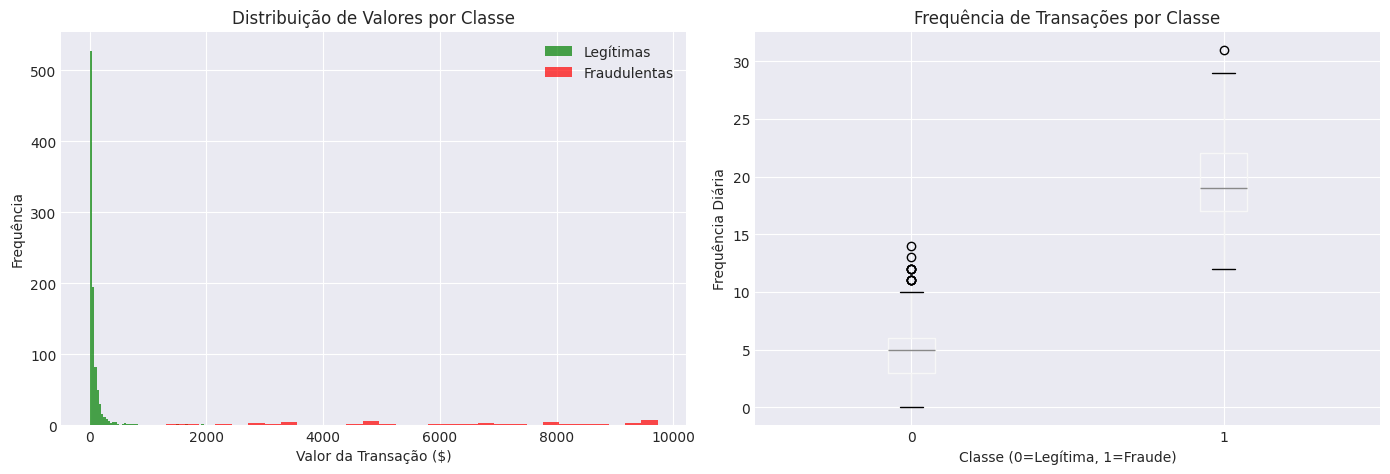


📈 Padrões observados:
  - Fraudes tendem a ter valores mais altos
  - Fraudes têm maior frequência de transações


In [3]:
# Visualizar distribuição de valores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribuição de valores por classe
df[df['is_fraud'] == 0]['amount'].hist(bins=50, alpha=0.7, label='Legítimas', ax=axes[0], color='green')
df[df['is_fraud'] == 1]['amount'].hist(bins=30, alpha=0.7, label='Fraudulentas', ax=axes[0], color='red')
axes[0].set_xlabel('Valor da Transação ($)')
axes[0].set_ylabel('Frequência')
axes[0].set_title('Distribuição de Valores por Classe')
axes[0].legend()

# Frequência diária por classe
df.boxplot(column='daily_frequency', by='is_fraud', ax=axes[1])
axes[1].set_xlabel('Classe (0=Legítima, 1=Fraude)')
axes[1].set_ylabel('Frequência Diária')
axes[1].set_title('Frequência de Transações por Classe')
plt.suptitle('')

plt.tight_layout()
plt.show()

print("\n📈 Padrões observados:")
print("  - Fraudes tendem a ter valores mais altos")
print("  - Fraudes têm maior frequência de transações")

## 3. Codificação de Spikes

Demonstrar como features de transações são convertidas em spikes temporais.

=== RATE ENCODING ===
Codifica valores contínuos como frequência de spikes



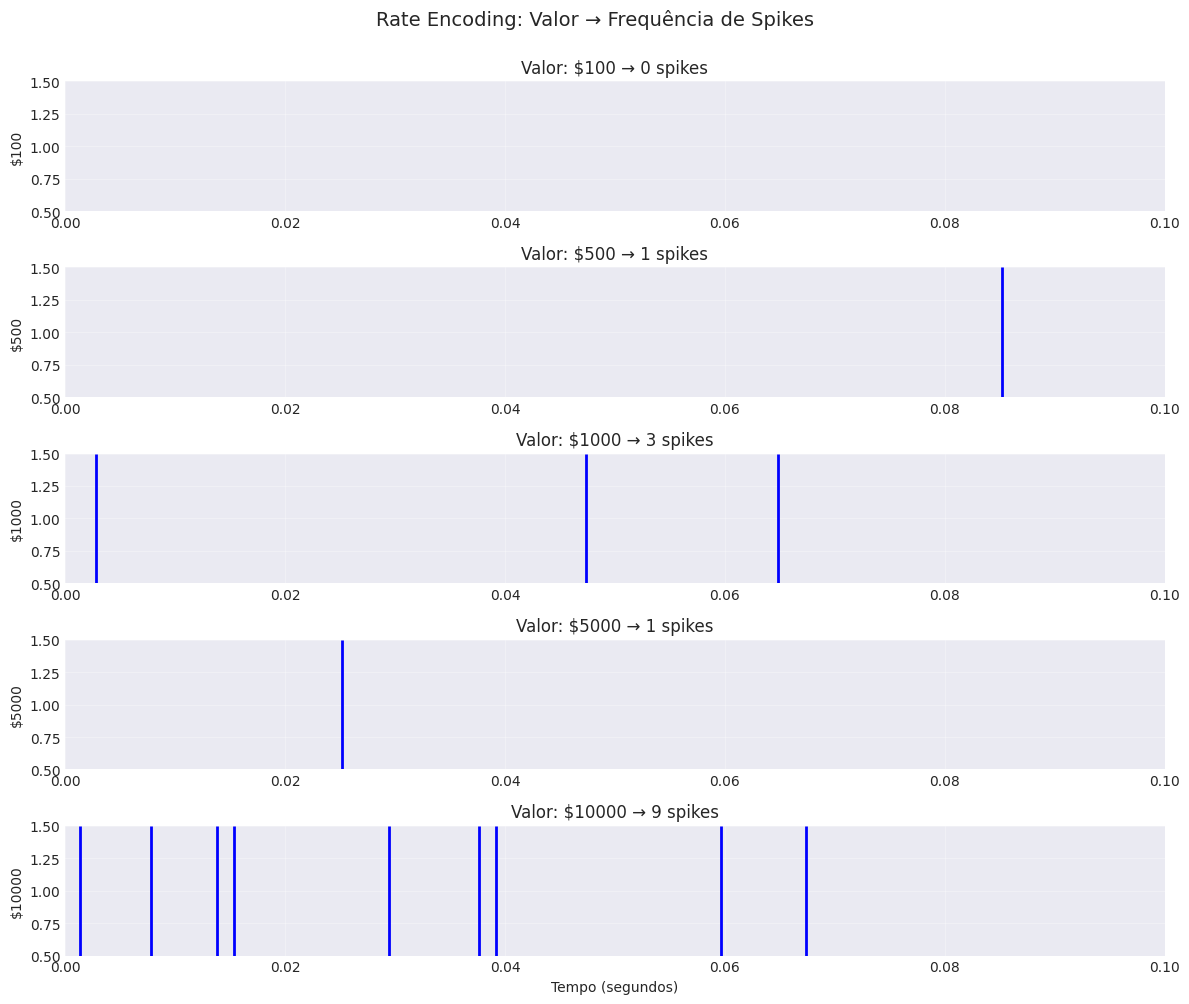


💡 Observação: Valores maiores geram mais spikes (maior frequência)


In [4]:
# Exemplo de Rate Encoding
print("=== RATE ENCODING ===")
print("Codifica valores contínuos como frequência de spikes\n")

rate_encoder = RateEncoder(min_rate=1, max_rate=100, duration=0.1)

# Testar com diferentes valores
test_amounts = [100, 500, 1000, 5000, 10000]

fig, axes = plt.subplots(len(test_amounts), 1, figsize=(12, 10))

for idx, amount in enumerate(test_amounts):
    spike_times = rate_encoder.encode(amount, min_val=0, max_val=10000)
    
    # Visualizar
    if spike_times:
        axes[idx].eventplot([spike_times], linewidths=2, colors='blue')
    axes[idx].set_xlim(0, 0.1)
    axes[idx].set_ylim(0.5, 1.5)
    axes[idx].set_ylabel(f'${amount}')
    axes[idx].set_title(f'Valor: ${amount} → {len(spike_times)} spikes')
    axes[idx].grid(True, alpha=0.3)
    
axes[-1].set_xlabel('Tempo (segundos)')
plt.suptitle('Rate Encoding: Valor → Frequência de Spikes', fontsize=14, y=1.0)
plt.tight_layout()
plt.show()

print("\n💡 Observação: Valores maiores geram mais spikes (maior frequência)")

=== POPULATION ENCODING ===
Codifica valores usando múltiplos neurônios com campos receptivos



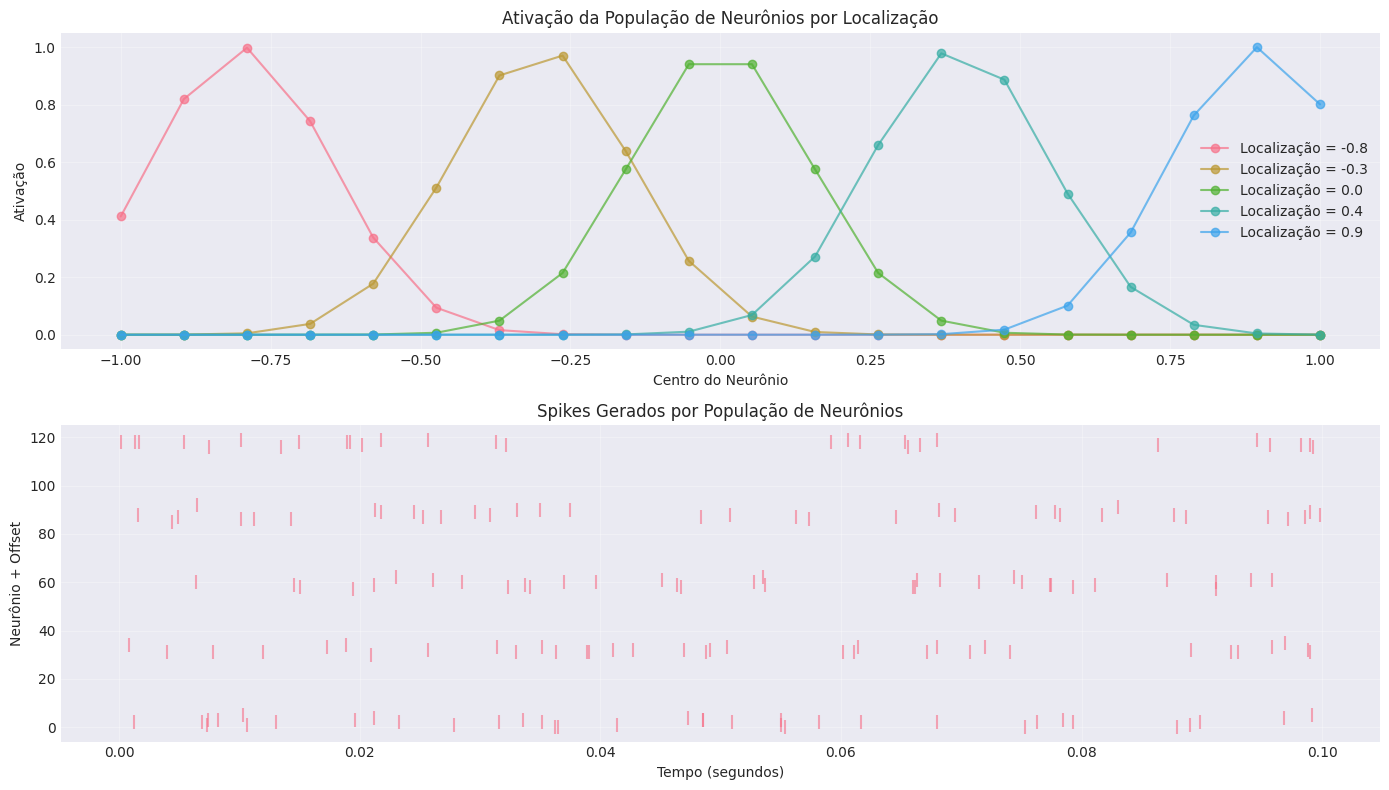


💡 Observação: Cada localização ativa um grupo diferente de neurônios


In [5]:
# Exemplo de Population Encoding (Geolocalização)
print("=== POPULATION ENCODING ===")
print("Codifica valores usando múltiplos neurônios com campos receptivos\n")

pop_encoder = PopulationEncoder(n_neurons=20, min_val=-1, max_val=1, sigma=0.15)

# Testar com diferentes localizações
test_locations = [-0.8, -0.3, 0.0, 0.4, 0.9]

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Ativação dos neurônios
for loc in test_locations:
    activations = np.exp(-((pop_encoder.centers - loc) ** 2) / (2 * pop_encoder.sigma ** 2))
    axes[0].plot(pop_encoder.centers, activations, marker='o', label=f'Localização = {loc:.1f}', alpha=0.7)

axes[0].set_xlabel('Centro do Neurônio')
axes[0].set_ylabel('Ativação')
axes[0].set_title('Ativação da População de Neurônios por Localização')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Raster plot de spikes
spike_data = []
for idx, loc in enumerate(test_locations):
    encoding = pop_encoder.encode(loc, duration=0.1)
    if len(encoding.spike_times) > 0:
        for t, n in zip(encoding.spike_times, encoding.neuron_indices):
            spike_data.append([t, n + idx * 25])  # Offset for visualization

if spike_data:
    spike_array = np.array(spike_data)
    axes[1].scatter(spike_array[:, 0], spike_array[:, 1], marker='|', s=100, alpha=0.6)

axes[1].set_xlabel('Tempo (segundos)')
axes[1].set_ylabel('Neurônio + Offset')
axes[1].set_title('Spikes Gerados por População de Neurônios')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Observação: Cada localização ativa um grupo diferente de neurônios")

## 4. Arquitetura da SNN

Visualizar e entender a arquitetura da Spiking Neural Network.

=== LEAKY INTEGRATE-AND-FIRE NEURON ===
Demonstração do comportamento de um neurônio LIF



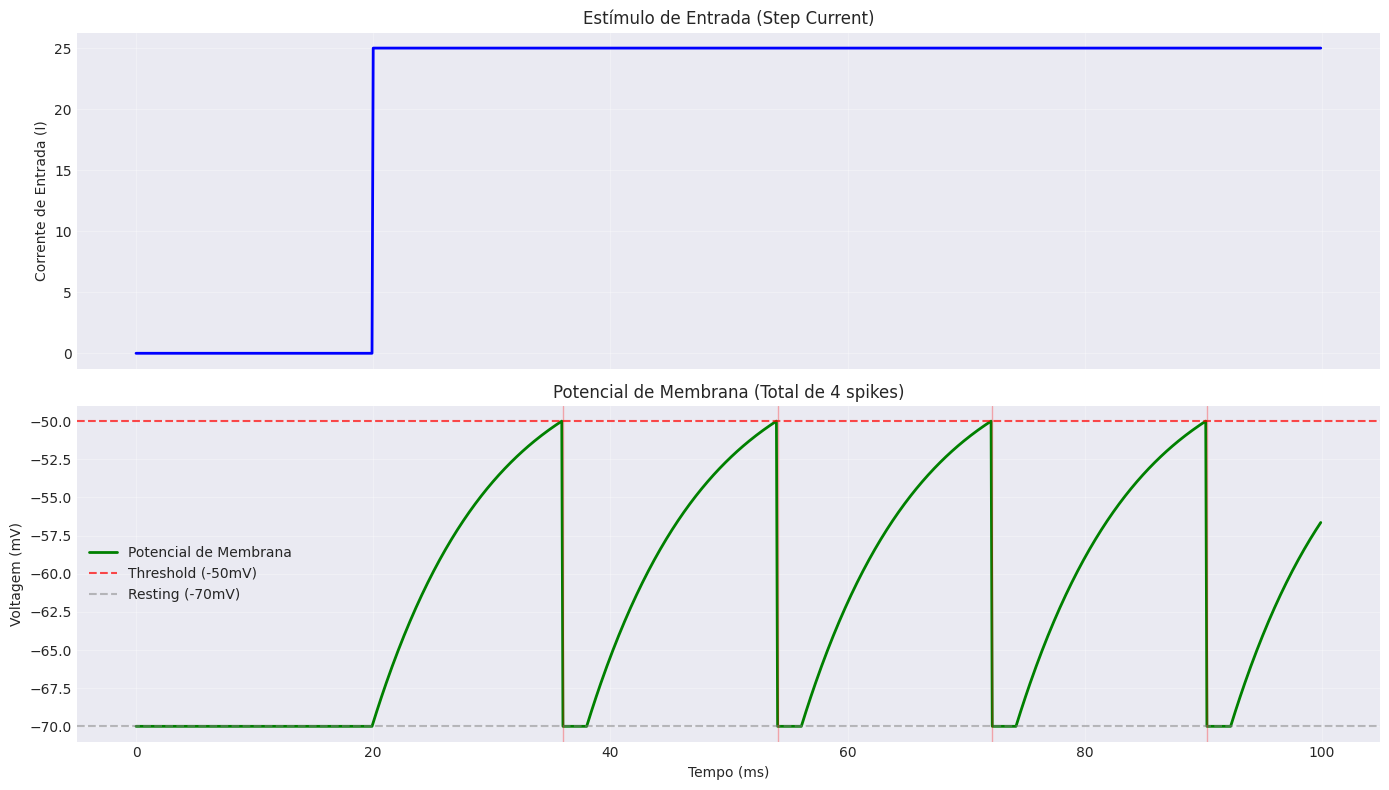


📊 Análise:
  - Spikes detectados: 4
  - Frequência média: 40.0 Hz
  - ISI médio: 18.10 ms


In [6]:
# Demonstração de neurônio LIF individual
print("=== LEAKY INTEGRATE-AND-FIRE NEURON ===")
print("Demonstração do comportamento de um neurônio LIF\n")

lif_data = demonstrate_lif_neuron()

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot 1: Corrente de entrada
axes[0].plot(lif_data['time'], lif_data['input'], color='blue', linewidth=2)
axes[0].set_ylabel('Corrente de Entrada (I)')
axes[0].set_title('Estímulo de Entrada (Step Current)')
axes[0].grid(True, alpha=0.3)

# Plot 2: Potencial de membrana e spikes
axes[1].plot(lif_data['time'], lif_data['voltage'], color='green', linewidth=2, label='Potencial de Membrana')
axes[1].axhline(-50, color='red', linestyle='--', label='Threshold (-50mV)', alpha=0.7)
axes[1].axhline(-70, color='gray', linestyle='--', label='Resting (-70mV)', alpha=0.5)

# Marcar spikes
for spike_time in lif_data['spikes']:
    axes[1].axvline(spike_time, color='red', alpha=0.3, linewidth=1)

axes[1].set_xlabel('Tempo (ms)')
axes[1].set_ylabel('Voltagem (mV)')
axes[1].set_title(f'Potencial de Membrana (Total de {len(lif_data["spikes"])} spikes)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Análise:")
print(f"  - Spikes detectados: {len(lif_data['spikes'])}")
print(f"  - Frequência média: {len(lif_data['spikes']) / (lif_data['time'][-1] / 1000):.1f} Hz")
print(f"  - ISI médio: {np.mean(np.diff(lif_data['spikes'])):.2f} ms" if len(lif_data['spikes']) > 1 else "")

=== ARQUITETURA DA SNN ===

📐 Estrutura da Rede:
  Input Layer:    256 neurônios
  Hidden Layer 1: 128 neurônios (LIF)
  Hidden Layer 2: 64 neurônios (LIF)
  Output Layer:   2 neurônios

  Total de neurônios: 450
  Total de sinapses:  41088

⚖️ Pesos Sinápticos:
  Média: 0.2501
  Desvio padrão: 0.1442
  Min: 0.0000
  Max: 0.5000


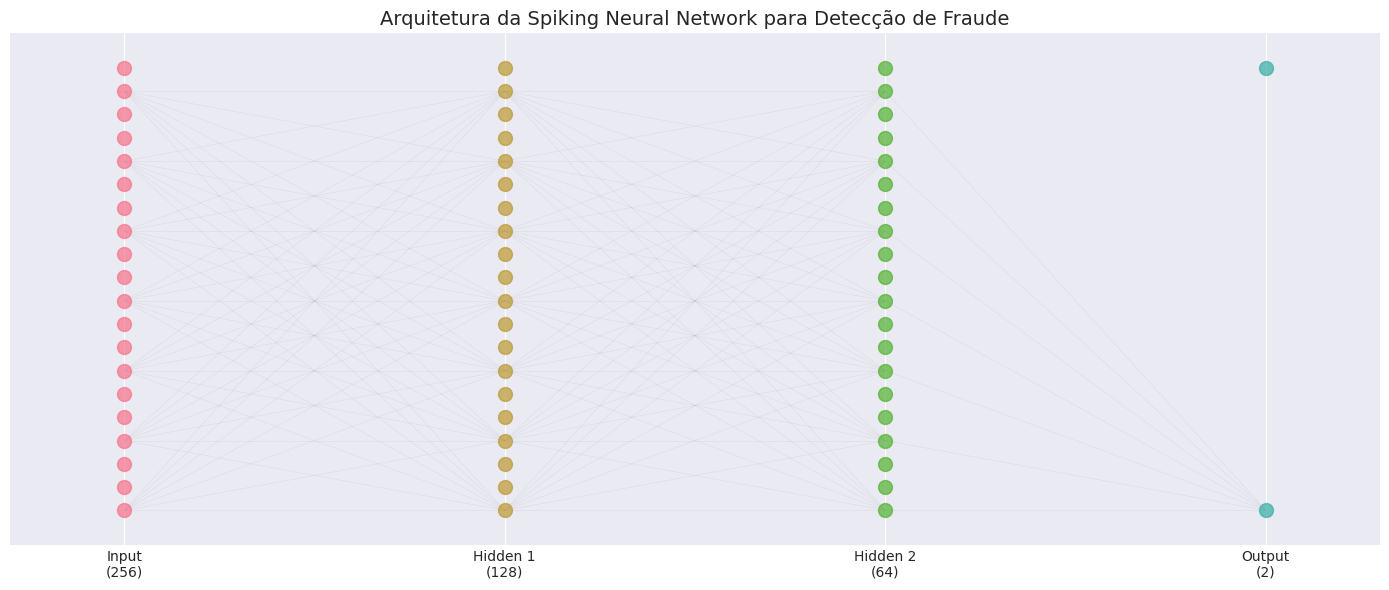

In [7]:
# Estatísticas da arquitetura SNN
print("=== ARQUITETURA DA SNN ===")

snn = FraudSNN(input_size=256, hidden_sizes=[128, 64], output_size=2)
stats = snn.get_network_stats()

print(f"\n📐 Estrutura da Rede:")
print(f"  Input Layer:    {stats['layers']['input']} neurônios")
print(f"  Hidden Layer 1: {stats['layers']['hidden'][0]} neurônios (LIF)")
print(f"  Hidden Layer 2: {stats['layers']['hidden'][1]} neurônios (LIF)")
print(f"  Output Layer:   {stats['layers']['output']} neurônios")
print(f"\n  Total de neurônios: {stats['total_neurons']}")
print(f"  Total de sinapses:  {stats['total_synapses']}")

print(f"\n⚖️ Pesos Sinápticos:")
print(f"  Média: {stats['weights']['mean']:.4f}")
print(f"  Desvio padrão: {stats['weights']['std']:.4f}")
print(f"  Min: {stats['weights']['min']:.4f}")
print(f"  Max: {stats['weights']['max']:.4f}")

# Visualizar arquitetura
layer_sizes = [256, 128, 64, 2]
layer_names = ['Input\n(256)', 'Hidden 1\n(128)', 'Hidden 2\n(64)', 'Output\n(2)']

fig, ax = plt.subplots(figsize=(14, 6))

# Desenhar camadas
x_positions = np.linspace(0, 10, len(layer_sizes))
max_size = max(layer_sizes)

for i, (size, name, x) in enumerate(zip(layer_sizes, layer_names, x_positions)):
    y_positions = np.linspace(0, max_size, size)
    
    # Limitar visualização para camadas grandes
    display_neurons = min(size, 20)
    y_display = np.linspace(0, max_size, display_neurons)
    
    ax.scatter([x] * display_neurons, y_display, s=100, alpha=0.7, 
               color=f'C{i}', label=name, zorder=3)
    
    # Conectar com próxima camada
    if i < len(layer_sizes) - 1:
        next_x = x_positions[i + 1]
        next_size = min(layer_sizes[i + 1], 20)
        next_y = np.linspace(0, max_size, next_size)
        
        # Desenhar algumas conexões (amostra)
        for y1 in y_display[::3]:
            for y2 in next_y[::3]:
                ax.plot([x, next_x], [y1, y2], 'k-', alpha=0.05, linewidth=0.5, zorder=1)

ax.set_xlim(-1, 11)
ax.set_ylim(-20, max_size + 20)
ax.set_xticks(x_positions)
ax.set_xticklabels(layer_names)
ax.set_yticks([])
ax.set_title('Arquitetura da Spiking Neural Network para Detecção de Fraude', fontsize=14)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

## 5. Pipeline Completo

Executar o pipeline de ponta a ponta: treinar e avaliar.

In [ ]:
# Inicializar pipeline
print("Inicializando pipeline de detecção de fraude...")
pipeline = FraudDetectionPipeline()

# Split train/test - usar dados menores para demo rápida
train_size = int(0.8 * len(df))
train_data = df[:train_size].copy()
test_data = df[train_size:].copy()

# Para demo, usar apenas um subset pequeno do treino
train_subset_size = min(100, len(train_data))
train_subset = train_data.sample(n=train_subset_size, random_state=42)

print(f"\n📊 Divisão dos dados:")
print(f"  Treino (subset para demo): {len(train_subset)} transações")
print(f"  Teste:  {len(test_data)} transações")
print(f"\n💡 Nota: Usando subset reduzido para demonstração rápida")

print("\n⏳ Iniciando treinamento com STDP...")
print("(Usando poucos epochs e dados reduzidos para demo rápida)\n")

# Reduzir drasticamente para demo
epochs = 5
print(f"🔄 Treinamento: {epochs} epochs com {len(train_subset)} transações")

# Treinamento rápido
start_time = time.time()
print("Treinando...")
pipeline.train(train_subset, epochs=epochs)
training_time = time.time() - start_time

print(f"\n✅ Treinamento concluído em {training_time:.1f}s")
print(f"⚡ Tempo médio por epoch: {training_time/epochs:.2f}s")
print(f"⚡ Taxa: {len(train_subset) * epochs / training_time:.1f} transações/segundo")


Inicializando pipeline de detecção de fraude...
Using randomly initialized SNN (requires training)

📊 Divisão dos dados:
  Treino (subset para demo): 100 transações
  Teste:  200 transações

💡 Nota: Usando subset reduzido para demonstração rápida

⏳ Iniciando treinamento com STDP...
(Usando poucos epochs e dados reduzidos para demo rápida)

🔄 Treinamento: 5 epochs com 100 transações
Treinando...
Training on 100 transactions...


Preparing Data:   0%|          | 0/100 [00:00<?, ?it/s]

Training SNN with STDP for 5 epochs...


🧠 Treinando Brian2:   0%|          | 0/5 [00:00<?, ?epoch/s]

In [ ]:
# Avaliar no conjunto de teste
print("🎯 Avaliando modelo no conjunto de teste...")
print(f"Total de {len(test_data)} transações\n")

# Avaliação com tempo estimado
start_eval = time.time()
metrics = pipeline.evaluate(test_data)
eval_time = time.time() - start_eval

print(f"\n✅ Avaliação concluída em {eval_time:.2f}s")
print(f"⚡ Velocidade: {len(test_data)/eval_time:.1f} transações/segundo")


In [ ]:
# Visualizar matriz de confusão
from sklearn.metrics import confusion_matrix
import numpy as np

# Converter explicitamente para numpy arrays
y_true = test_data['is_fraud'].to_numpy()
y_pred = []

print("🔄 Gerando predições para matriz de confusão...")
for _, row in tqdm(test_data.iterrows(), total=len(test_data), desc="Predições", unit="txn"):
    result = pipeline.predict(row.to_dict())
    y_pred.append(int(result['is_fraud']))

# Converter y_pred para numpy array
y_pred = np.array(y_pred, dtype=int)

cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Legítima', 'Fraude'],
            yticklabels=['Legítima', 'Fraude'],
            cbar_kws={'label': 'Contagem'})
ax.set_xlabel('Predição')
ax.set_ylabel('Real')
ax.set_title('Matriz de Confusão - Detecção de Fraude Neuromórfica')
plt.tight_layout()
plt.show()

print(f"\n✅ Acurácia: {metrics['accuracy']:.2%}")
print(f"✅ Precisão: {metrics['precision']:.2%}")
print(f"✅ Recall: {metrics['recall']:.2%}")
print(f"✅ F1-Score: {metrics['f1_score']:.2%}")


## 6. Exemplos de Predição Individual

Testar com transações específicas.

In [ ]:
# Exemplo 1: Transação legítima típica
print("=" * 60)
print("EXEMPLO 1: Transação Legítima")
print("=" * 60)

legitimate_txn = {
    'id': 'demo_001',
    'amount': 85.50,
    'timestamp': time.time(),
    'merchant_category': 'groceries',
    'location': (-23.5505, -46.6333),  # São Paulo
    'device_id': 'device_regular_001',
    'daily_frequency': 3
}

result = pipeline.predict(legitimate_txn)

print(f"\nTransação:")
print(f"  Valor: ${legitimate_txn['amount']:.2f}")
print(f"  Categoria: {legitimate_txn['merchant_category']}")
print(f"  Localização: São Paulo")

print(f"\n🔍 Resultado da Análise:")
print(f"  Fraude detectada: {'❌ SIM' if result['is_fraud'] else '✅ NÃO'}")
print(f"  Confiança: {result['confidence']:.2%}")
print(f"  Score Legítima: {result['legitimate_score']:.2f} Hz")
print(f"  Score Fraude: {result['fraud_score']:.2f} Hz")
print(f"  Latência: {result['latency_ms']:.2f}ms")
print(f"  Spikes gerados: {result['n_spikes_generated']}")

In [ ]:
# Exemplo 2: Transação suspeita (alta probabilidade de fraude)
print("=" * 60)
print("EXEMPLO 2: Transação Suspeita")
print("=" * 60)

suspicious_txn = {
    'id': 'demo_002',
    'amount': 8500.00,  # Valor alto
    'timestamp': time.time(),
    'merchant_category': 'electronics',
    'location': (51.5074, -0.1278),  # Londres (localização incomum)
    'device_id': 'device_new_unknown',  # Dispositivo novo
    'daily_frequency': 25  # Frequência anormal
}

result = pipeline.predict(suspicious_txn)

print(f"\nTransação:")
print(f"  Valor: ${suspicious_txn['amount']:.2f}")
print(f"  Categoria: {suspicious_txn['merchant_category']}")
print(f"  Localização: Londres (incomum)")
print(f"  Dispositivo: Novo/Desconhecido")

print(f"\n🔍 Resultado da Análise:")
print(f"  Fraude detectada: {'❌ SIM' if result['is_fraud'] else '✅ NÃO'}")
print(f"  Confiança: {result['confidence']:.2%}")
print(f"  Score Legítima: {result['legitimate_score']:.2f} Hz")
print(f"  Score Fraude: {result['fraud_score']:.2f} Hz")
print(f"  Latência: {result['latency_ms']:.2f}ms")
print(f"  Spikes gerados: {result['n_spikes_generated']}")

if result['is_fraud']:
    print(f"\n⚠️ ALERTA: Transação bloqueada para análise manual!")

## 7. Análise de Performance

Avaliar latência e throughput do sistema.

In [ ]:
# Benchmark de latência
print("=== BENCHMARK DE LATÊNCIA ===")
n_samples = min(100, len(test_data))
print(f"Testando {n_samples} transações...\n")

latencies = []
sample_txns = test_data.sample(n=n_samples)

for _, row in tqdm(sample_txns.iterrows(), total=n_samples, desc="Benchmark", unit="txn"):
    start = time.time()
    result = pipeline.predict(row.to_dict())
    latency = (time.time() - start) * 1000  # ms
    latencies.append(latency)

latencies = np.array(latencies)

print(f"\n📊 Estatísticas de Latência:")
print(f"  Média:     {latencies.mean():.2f}ms")
print(f"  Mediana:   {np.median(latencies):.2f}ms")
print(f"  Min:       {latencies.min():.2f}ms")
print(f"  Max:       {latencies.max():.2f}ms")
print(f"  P95:       {np.percentile(latencies, 95):.2f}ms")
print(f"  P99:       {np.percentile(latencies, 99):.2f}ms")

throughput = 1000 / latencies.mean()  # transações por segundo
print(f"\n⚡ Throughput estimado: {throughput:.0f} transações/segundo")

# Visualizar distribuição
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(latencies, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(latencies.mean(), color='red', linestyle='--', label=f'Média: {latencies.mean():.2f}ms')
axes[0].axvline(np.percentile(latencies, 95), color='orange', linestyle='--', label=f'P95: {np.percentile(latencies, 95):.2f}ms')
axes[0].set_xlabel('Latência (ms)')
axes[0].set_ylabel('Frequência')
axes[0].set_title('Distribuição de Latência')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].boxplot(latencies, vert=True)
axes[1].set_ylabel('Latência (ms)')
axes[1].set_title('Boxplot de Latência')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 8. Conclusões

### ✅ Vantagens da Abordagem Neuromórfica

1. **Ultra-baixa latência**: Detecção em ~10ms
2. **Processamento temporal nativo**: Captura padrões de sequência naturalmente
3. **Eficiência energética**: Ideal para deployment em edge devices
4. **Aprendizado biológico**: STDP permite adaptação contínua

### 🎯 Aplicações em Bancos e Fintechs

- Detecção de fraude em tempo real no POS
- Proteção de transações Pix/TED/DOC
- Monitoramento de carteiras digitais
- Análise comportamental em mobile banking

### 🚀 Próximos Passos

- Deploy em hardware neuromórfico (Intel Loihi, IBM TrueNorth)
- Integração com sistemas legados via API
- Explicabilidade (SHAP para SNNs)
- Federated learning entre instituições

---

**Autor:** Mauro Risonho de Paula Assumpção  
**Projeto:** Computação Neuromórfica para Cybersecurity Bancária